# Fitting probabilistic models using OWL  

In this notebook we will fit three probabilistic models using OWL. The first two will be simple models with a single parameter: exponential distributions and Poisson distributions.

The last example will be a Laplacian mixture model.

To use this tutorial, you should have installed the owl package.

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.special import factorial, gammaln

## Exponential distribution

We first import the class OWLModel from owl.models. We then define the class Exponential by extending the OWLModel class. When initializing the super class, we must pass the dimension of the probability vector (n) as well as a probability vector w (or None). Passing to this super class will initialize the vector self.w, which will be of length n. If the w passed to the super class initialization was None, then self.w will be the all ones vector of length n.

In the below code, we initialize the Exponential object by passing in a numpy array X which contains the data points $(x_1, \ldots, x_n)$. For simplicity, we will assume that all the elements of X are unique. Exponential distributions have a single parameter $\lambda > 0$ and induce the density:

$$p_\lambda(x) = \lambda e^{-\lambda x}.$$

We then need to define two functions: maximize_weighted_likelihood and log_likelihood.

log_likelihood should return the log-likelihoods of the data points $x_1, \ldots, x_n$ under the current model parameter. In our case, this amounts to returning the vector $(\log p_\lambda(x_1), \ldots \log p_\lambda(x_1))$.


maximize_weighted_likelihood should set the parameters of the model to maximize the weighted log-likelihood of the data points. If the current weight vector is $w = (w_1, \ldots, w_n)$, this amounts to solving the optimization problem:

$$ \lambda^* = \arg \max_{\lambda} \sum_{i=1}^n w_i \log p_\lambda(x_i).$$

In [2]:
## Import OWL module
from owl.models import OWLModel

'''
    Simple univariate exponential distribution.
'''
class Exponential(OWLModel):
    def __init__(self, 
        X: np.ndarray, ## Input samples (1-dimensional)
        w:np.ndarray = None, ## Weights over the samples (set to None for uniform)
        **kwargs
        ):
        self.X = X.copy()
        n  = len(X)
        super().__init__(n=n, w=w, **kwargs)

        self.lam = 1.0 ## Parameter of the exponential distribution
    
    def maximize_weighted_likelihood(self, **kwargs):
        self.lam = np.sum(self.w)/np.dot(self.w, self.X)

    def log_likelihood(self):
        return( np.log(self.lam) - (self.lam*self.X) )

Now we will generate some data. Here, 95% of the data will come from an exponential distribution, and 5% of the data will be corrupted to come from a Normal distribution.

In [3]:
## Set our random seed
np.random.seed(100)

## Generate data from an exponential distribution
n = 1000
lam = 5.0
x = np.random.exponential(scale=(1./lam), size=n)

## Randomly corrupt 5% of the data
epsilon = 0.05
corrupt_inds = np.random.choice(n, size=int(n*epsilon), replace=False)
for i in corrupt_inds:
    x[i] = 5.0 + np.random.standard_normal()

To fit a maximum likelihood estimator, we only need to initialize our Exponential class with the data and call the maximize_weighted_likehood() method.

To fit an OWL estimator, we first import the class L1Ball from owl.ball. To initialize this class, we need to pass the size of the weight vector w into this class and the radius of the ball. In our case, the size of the weight vector is n and the radius we will choose is epsilon. Then we need to call the fit_owl() method, passing in our ball object and the number of alternating optimization steps.

100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


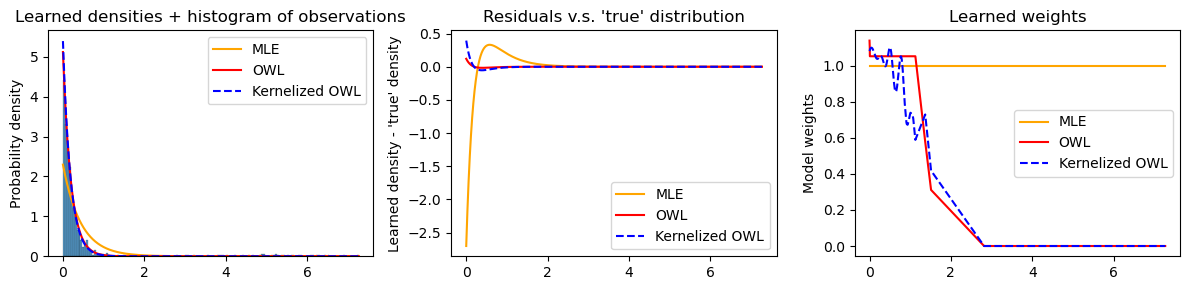

In [4]:
## Fit a maximum likelihood estimate to the data
mle = Exponential(X=x)
mle.maximize_weighted_likelihood()

## Fit an owl estimate to the data
from owl.ball import L1Ball
owl = Exponential(X=x)
l1ball = L1Ball(n=n, r=epsilon)
owl.fit_owl(ball=l1ball, n_iters=10, verbose=True)


from owl.kde import RBFKDE
kde = RBFKDE(X=x[:,np.newaxis], bandwidth=0.01)
kern_owl = Exponential(X=x)
kern_owl.fit_owl(ball=l1ball, kde=kde, n_iters=10, verbose=True)


## Plot model fit of mle v.s. true model
locs = np.linspace(np.min(x), np.max(x), 1000)
true_y = lam*np.exp(-lam*locs)
mle_y = mle.lam*np.exp(-mle.lam*locs)
owl_y = owl.lam*np.exp(-owl.lam*locs)
kern_owl_y = kern_owl.lam*np.exp(-kern_owl.lam*locs)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
axs[0].plot(locs, mle_y, c='orange', label="MLE")
axs[0].plot(locs, owl_y, c='red', label="OWL")
axs[0].plot(locs, kern_owl_y, c='blue', linestyle='--', label="Kernelized OWL")
sns.histplot(x, stat='density', ax=axs[0])
axs[0].legend()
axs[0].set_ylabel("Probability density")
axs[0].set_title('Learned densities + histogram of observations')

## Plot residuals
axs[1].plot(locs, (mle_y -  true_y), c='orange', label="MLE")
axs[1].plot(locs, (owl_y -  true_y), c='red', label="OWL")
axs[1].plot(locs, (kern_owl_y-  true_y), c='blue', linestyle='--', label="Kernelized OWL")
axs[1].set_ylabel("Learned density - 'true' density")
axs[1].legend()
axs[1].set_title("Residuals v.s. 'true' distribution")

## Plot weights
idx = np.argsort(x)
axs[2].plot(mle.X[idx], mle.w[idx], c='orange', label='MLE')
axs[2].plot(owl.X[idx], owl.w[idx], c='red', label='OWL')
axs[2].plot(kern_owl.X[idx], kern_owl.w[idx], c='blue', linestyle='--', label='Kernelized OWL')
axs[2].set_ylabel("Model weights")
axs[2].legend()
axs[2].set_title("Learned weights")
plt.tight_layout()
plt.show()

## Poisson distribution

Now we will consider fitting Poisson distributions. Here, the observations are now discrete (taking values on the non-negative integers) and it no longer makes sense to treat all the observations as unique. We will instead pass in two vectors, locs (which tracks the integer positions of the observations) and counts (which will count the number of observations were at those positions) so that counts[i] = # of times we saw the observation locs[i].

We will use the default weight vector w=counts and the log_likelihood function will return the log-likehoods of the values in loc. 

In [5]:
class Poisson(OWLModel):
    def __init__(self, 
        locs: np.ndarray, ## Locations of observations (1-dimensional, length n_loc)
        counts: np.ndarray, ## Counts observed at each location (1-dimensional, length n_loc)
        w:np.ndarray = None, ## Weights over the locations (set to None to match counts)
        **kwargs
        ):
        self.locs = locs.copy()
        self.counts = counts.copy()
        n_loc = len(self.locs)
        if w is None:
            w = counts

        super().__init__(n=n_loc, w=w, **kwargs)
        self.lam = 1.0

    def maximize_weighted_likelihood(self, **kwargs):
        self.lam = np.dot(self.w, self.locs)/np.sum(self.w)

    def log_likelihood(self):
        return( self.locs * np.log(self.lam) - self.lam - gammaln( (self.locs + 1) ) )

We will generate some data where 95% of the data will come from a Poisson distribution, and 5% of the data will be corrupted to come from the uniform distribution over some interval.

In [6]:
## Generate data from an poisson distribution
n = 1000
lam = 5.0
x = np.random.poisson(lam=lam, size=n)

## Randomly corrupt 5% of the data
epsilon = 0.05
corrupt_inds = np.random.choice(n, size=int(n*epsilon), replace=False)
for i in corrupt_inds:
    x[i] = np.random.choice(np.arange(10, 50)) ## Uniform distribution over {10,11,12...,49}

locs, counts = np.unique(x, return_counts=True)

Fitting a maximum likelihood estimator follows the exact same steps as before.


To fit an OWL estimator, we again will instantiate the L1Ball class. However, this time, we need to change the empirical distribution that we pass into the L1Ball (the center parameter) to match the empirical distribution over locs. 

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 193.56it/s]


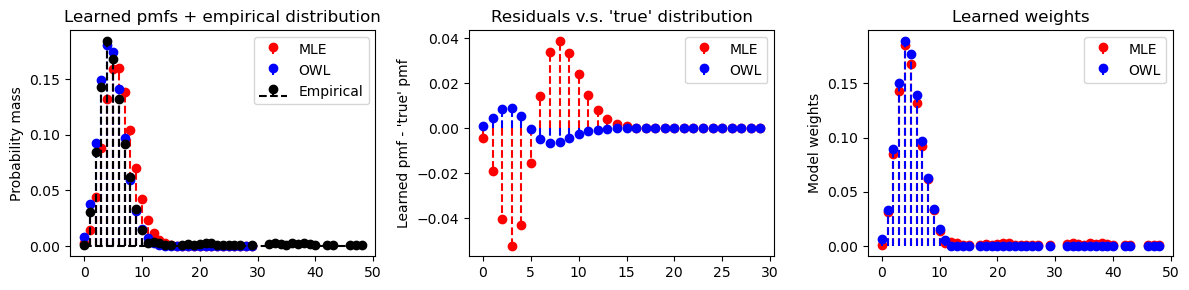

In [7]:
## Fit a maximum likelihood estimate to the data
mle = Poisson(locs=locs, counts=counts)
mle.maximize_weighted_likelihood()

## Fit an OWL estimate to the data
owl = Poisson(locs=locs, counts=counts)
m = len(locs)
l1ball = L1Ball(n=m, r=epsilon, center=(counts/np.sum(counts)))
owl.fit_owl(ball=l1ball, n_iters=10, verbose=True)


## Plot model fit of mle v.s. true model
ks = np.arange(30)
true_y = np.power(lam, ks) * np.exp(-lam)/factorial(ks)
mle_y = np.power(mle.lam, ks) * np.exp(-mle.lam)/factorial(ks)
owl_y = np.power(owl.lam, ks) * np.exp(-owl.lam)/factorial(ks)


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
axs[0].stem(ks, mle_y, linefmt='r--', markerfmt='ro', basefmt=' ', label='MLE')
axs[0].stem(ks, owl_y, linefmt='b--', markerfmt='bo', basefmt=' ', label='OWL')
axs[0].stem(locs, counts/np.sum(counts), linefmt='k--', markerfmt='ko', basefmt='k--', label='Empirical')
axs[0].legend()
axs[0].set_ylabel("Probability mass")
axs[0].set_title('Learned pmfs + empirical distribution')

## Plot residuals
axs[1].stem(ks, (mle_y -  true_y), linefmt='r--', markerfmt='ro', basefmt=' ', label='MLE')
axs[1].stem(ks, (owl_y -  true_y), linefmt='b--', markerfmt='bo', basefmt=' ', label='OWL')
axs[1].set_ylabel("Learned pmf - 'true' pmf")
axs[1].legend()
axs[1].set_title("Residuals v.s. 'true' distribution")

## Plot weights
axs[2].stem(owl.locs, mle.w/np.sum(mle.w), linefmt='r--', markerfmt='ro', basefmt=' ', label='MLE')
axs[2].stem(owl.locs, owl.w/np.sum(owl.w), linefmt='b--', markerfmt='bo', basefmt=' ', label='OWL')
axs[2].set_ylabel("Model weights")
axs[2].legend()
axs[2].set_title("Learned weights")
plt.tight_layout()
plt.show()

## Mixtures of Laplacians

To fit a mixture model, we first import the OWLMixtureModel class from owl.mixture_models. Here we need to define 5 functions: reinitialize, log_likehood, E_step, hard_M_step (for fitting an OWL model), and soft_M_step (for fitting a maximum likelihood model. The model initialization should also take as input a boolean variable called hard, indicating whether or not we will be using hard EM or soft EM. 

Reinitialize should give a fresh random initialization of the model parameters. It should also take as input a boolean indicating whether or not the weight vector w should be reset.

E_step should implement the classical E-step from the EM algorithm.

soft_M_step should implement the classical M-step from the EM algorithm.

hard_M_step should implement a *weighted* hard M-step. 

log_likelihood should return the log-likelood of the data under the current model.

In [8]:
from owl.mixture_models import OWLMixtureModel
from scipy.spatial.distance import cdist
from scipy.special import logsumexp

## Find the point mu that minimizes the weighted sum of absolute deviations:
##  sum_i w[i] | x[i] - mu |
def weighted_median(x:np.ndarray, w:np.ndarray, is_sorted:bool=False):
    if not is_sorted:
        idx = np.argsort(x)
        w_ = w[idx]
        x_ = x[idx]
    else:
        w_ = w
        x_ = x

    w_cumul = np.cumsum(w_)
    m_idx = np.where(w_cumul > (np.sum(w_) - w_cumul))[0][0]
    return(x_[m_idx])

class LaplaceMM(OWLMixtureModel):
    def __init__(self, X:np.ndarray, K:int, w: np.ndarray = None, hard: bool = True, em_steps: int = 20, **kwargs):
        self.X = np.sort(X.copy()) ## Sort the x's
        n  = len(X)
        super().__init__(n=n, w=w, hard=hard, em_steps=em_steps, **kwargs)

        self.K = K
        self.pi = np.ones(self.K)/self.K
        self.mu = np.zeros(self.K)
        self.b = np.ones(self.K)
        
        ## Smallest pairwise distance
        self.b_min = 2*np.median(np.ediff1d(self.X))
        self.b_max = np.std(self.X)
        
        self.reinitialize(reset_w=False)


    def reinitialize(self, reset_w: bool, **kwargs) -> None:
        if reset_w:
            self.w = np.ones(self.n)
        
        self.z = np.random.choice(self.K, size=self.n, replace=True)

        ## Take M step
        self.hard_M_step()

    def hard_M_step(self, **kwargs): ## Should be weighted
        for k in range(self.K):
            mask = self.z==k
            cluster_size = np.sum(mask)
            cluster_weight = np.sum(self.w[mask])
            if (cluster_weight > 0) and (cluster_size > 1):
                self.mu[k] = weighted_median(self.X[mask], self.w[mask], is_sorted=True)
                self.b[k] = np.dot(self.w[mask], np.abs( self.X[mask] - self.mu[k]))/cluster_weight
            elif (cluster_size == 1):
                self.mu[k] = np.squeeze(self.X[mask])
                self.b[k] = 0.0
            else:
                idx = np.random.choice(self.n)
                self.z[idx] = k
                self.mu[k] = self.X[idx]
                self.b[k] = 0.0
                cluster_size = 1
            self.pi[k] = cluster_size/self.n
        self.pi = self.pi/np.sum(self.pi)
        self.b = np.clip(self.b, a_min=self.b_min, a_max=self.b_max)

    def soft_M_step(self, **kwargs):

        self.pi = np.mean(self.probs, axis=0)
        self.pi = self.pi/np.sum(self.pi)

        for k in range(self.K):
            if self.pi[k] > 0:
                self.mu[k] = weighted_median(self.X, w=self.probs[:,k], is_sorted=True)
                self.b[k] = np.dot(self.probs[:,k], np.abs( self.X - self.mu[k]))/np.sum(self.probs[:,k])
            else:
                idx = np.random.choice(self.n)
                self.mu[k] = self.X[idx]
                self.b[k] = self.b_min

    def E_step(self, **kwargs):
        distances = cdist(self.X[:,np.newaxis], self.mu[:,np.newaxis], metric='minkowski', p=1.)
        with np.errstate(divide = 'ignore'):
            log_probs = np.log(self.pi) - np.log(2*self.b) - distances/self.b
        probs = np.exp( log_probs - np.max(log_probs, axis=1, keepdims=True) )
        self.probs = probs/np.sum(probs, axis=1, keepdims=True)

        self.z = np.argmax(log_probs, axis=1)
        
    def log_likelihood(self):
        if self.hard:
            with np.errstate(divide = 'ignore'):
                bs = self.b[self.z]
                return( -np.log(2*bs) - np.abs(self.X - self.mu[self.z])/bs)
        else:
            distances = cdist(self.X[:,np.newaxis], self.mu[:,np.newaxis], metric='minkowski', p=1.) ## n x K
            with np.errstate(divide = 'ignore'):
                expanded_result = np.log(self.pi) - np.log(2*self.b) - distances/self.b
                return(logsumexp(expanded_result, axis=1))
        
    def probability(self, x:np.ndarray):
        probs = np.zeros(len(x))
        for k in range(self.K):
            probs += self.pi[k] * (0.5/self.b[k]) * np.exp(- np.abs(x - self.mu[k]))
        return(probs)
        

In [9]:
## Generate from an equal mixture of Laplacians
K = 3
n = 1000
mu = np.array([-15, 0, 15])
b = np.array([1, 2, 1])
z = np.random.choice(K, size=n, replace=True)
x = np.empty(n)
for i, k in enumerate(z):
    x[i] = np.random.laplace(loc=mu[k], scale=b[k])

## Corrupt random 5% of the data
idx = np.random.choice(n, size=int(n*epsilon), replace=False)
for i in idx:
    x[i] = np.random.uniform(low=30.0, high=50.0)

To fit mixture models, we import fit_mle and fit_owl from owl.mixture_models. These functions will use random restarts on top of the EM algorithm or the OWL procedure.

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 17.59it/s]


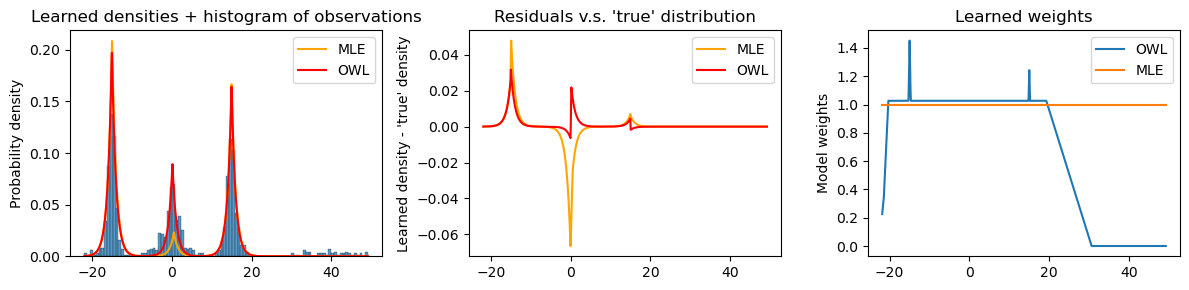

In [10]:
from owl.mixture_models import fit_mle, fit_owl

mle = LaplaceMM(X=x, K=K, hard=True)
mle = fit_mle(mle)

owl = LaplaceMM(X=x, K=K, hard=True)
l1ball = L1Ball(n=n, r=(1.5*epsilon))
owl = fit_owl(model=owl, ball=l1ball, repeats=10, admmsteps=2000, verbose=True)

true_model = LaplaceMM(X=x, K=K)
true_model.mu = mu
true_model.b = b


locs = np.linspace(np.min(x), np.max(x), 1000)
true_y = true_model.probability(locs)
mle_y = mle.probability(locs)
owl_y = owl.probability(locs)


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

axs[0].plot(locs, mle_y, c='orange', label="MLE")
axs[0].plot(locs, owl_y, c='red', label="OWL")
sns.histplot(x, stat='density', bins=100, ax=axs[0])
axs[0].legend()
axs[0].set_ylabel("Probability density")
axs[0].set_title('Learned densities + histogram of observations')


## Plot residuals
axs[1].plot(locs, (mle_y -  true_y), c='orange', label="MLE")
axs[1].plot(locs, (owl_y -  true_y), c='red', label="OWL")
axs[1].set_ylabel("Learned density - 'true' density")
axs[1].legend()
axs[1].set_title("Residuals v.s. 'true' distribution")



## Plot weights
axs[2].plot(owl.X, owl.w, label="OWL")
axs[2].plot(mle.X, mle.w, label="MLE")
axs[2].set_ylabel("Model weights")
axs[2].legend()
axs[2].set_title("Learned weights")
plt.tight_layout()
plt.show()
